In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy as sc
import logging
import glob
from functools import lru_cache
import time


In [59]:

# Global cache for device combinations by width to avoid rebuilding
DEVICE_COMBS = {}

@lru_cache(maxsize=128)
def unitcell_leads(w,d,t,e,l):
    # convert to native python types to ensure stable hashing for caching
    w = float(w); d = float(d); t = float(t); e = float(e); l = int(l)
    # logger.debug("unitcell_leads called with w=%s, d=%s, t=%s, e=%s, l=%s", w, d, t, e, l)
    n = l
    H = (w + 1J * d - e) * np.eye(n,dtype=complex)
    # set nearest-neighbour (adjacent) hopping terms
    if n > 1:
        ind = np.arange(0, n-1, 1)
        H[ind, ind+1] = t
        H[ind+1, ind] = t
    # logger.debug("unitcell_leads returning matrix of shape %s", H.shape)
    return H

@lru_cache(maxsize=128)
def unitcell_leads_inv(w,d,t,e,l):
    # cached inverse of unitcell_leads
    w = float(w); d = float(d); t = float(t); e = float(e); l = int(l)
    mat = unitcell_leads(w,d,t,e,l)
    try:
        inv = np.linalg.inv(mat)
    except np.linalg.LinAlgError:
        logger.exception("Failed to invert unitcell_leads for parameters %s", (w,d,t,e,l))
        raise
    return inv


def computed_leads(l):
    """Find existing lead files using glob instead of checking every w step.
    This avoids looping over all possible w values and calling os.path.exists repeatedly.
    """
    leads = {}
    # logger.debug("computed_leads scanning for lead files for l=%s using glob", l)
    pattern = os.path.expanduser(f'~/Desktop/backup/leads/leads_{l}_w_*.csv')
    for fn in glob.glob(pattern):
        try:
            base = os.path.basename(fn)
            # expect format leads_{l}_w_{w:.2f}.csv
            parts = base.rsplit('_w_', 1)
            if len(parts) != 2:
                # logger.debug("Skipping file with unexpected name format: %s", base)
                continue
            w_str = parts[1].rsplit('.csv', 1)[0]
            w = float(w_str)
            leads[w] = np.loadtxt(fn, delimiter=',', dtype=complex)
            # logger.debug("Loaded lead file %s for w=%s", fn, w)
        except Exception:
            logger.exception("Failed to load lead file %s", fn)
    # logger.debug("computed_leads found %s lead entries", len(leads))
    return leads


In [60]:


@lru_cache(maxsize=1024)
def chosen_for_config(n, width, config):
    """Return the chosen (n) device_combs rows for a given config (seed).
    This is cached so the RNG and selection run once per (n,width,config).
    """
    width = int(width); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    """Backward-compatible factory that returns a function drawing from cached chosen rows.
    But we no longer rebuild device_combs every call.
    """
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed



In [6]:
chosen_for_config(10, 25,1)

array([[56,  6],
       [11, 22],
       [51,  1],
       [94, 18],
       [17, 13],
       [80,  9],
       [25, 17],
       [26,  5],
       [47, 18],
       [96, 10]])

In [61]:

def unidevice(w,d,t,e,l,config,n,numberofunitcell, combs_fn=None):
    """Build the unit device matrix for a single seed (config).
    Accept an optional combs_fn to avoid recreating selection logic repeatedly.
    """
    # logger.debug("unidevice called with w=%s, d=%s, t=%s, e=%s, l=%s, config=%s, n=%s, numberofunitcell=%s", w,d,t,e,l,config,n,numberofunitcell)
    if combs_fn is None:
        combs_fn = possible_combs(n, l)
    imps = combs_fn(config)
    x = imps[:, 0]
    y = imps[:, 1]
    z = int(numberofunitcell)
    mat = unitcell_leads(w, d, t, e, l)
    # logger.debug("unidevice initial mat shape %s", mat.shape)
    if np.any(z == x):
        indices = np.where(x == z)[0]
        y1 = y[indices]
        # logger.debug("unidevice matched indices %s with y values %s", indices, y1)
        # apply modifications per index (correct per-index assignment)
        for i in y1:
            mat[int(i), int(i)] = (w + 1j * d - 0.5)
        # logger.debug("unidevice modified mat at indices %s", y1)
        return mat

    # logger.debug("unidevice no modification needed")
    return mat


In [78]:
size = 15
leads_size = computed_leads(size)

In [79]:
def device(w, d, t, e, l, config, n):

    
    hopp = np.eye(l, dtype=complex)
    w = round(w, 2)

    # Use cached inverse of unitcell_leads if available
    try:
        unit = unitcell_leads_inv(w, d, t, e, l)
    except:
        unit = np.linalg.inv(unitcell_leads(w, d, t, e, l))

    g = unit.copy()
    iden = np.eye(l, dtype=complex)

    G = leads_size.get(w)
    if G is None:
        return np.nan

    g_hopp = g @ hopp
    max_iter = 100
    combs_fn = possible_combs(n, l)

    # Run fixed number of iterations (no convergence check)
    for i in range(max_iter):
        mat = unidevice(w, d, t, e, l, config, n, i, combs_fn=combs_fn)
        g_d = np.linalg.inv(mat)
        A = iden - g_d @ hopp @ G @ hopp
        G = np.linalg.solve(A, g_d)

    left_device = G
    right = leads_size.get(w)
    if right is None:
        return np.nan

    # Connect left and right leads
    c_l_1 = iden - right @ hopp @ left_device @ hopp
    c_l = np.linalg.solve(c_l_1, left_device)
    c_l_2 = iden - left_device @ hopp @ right @ hopp
    c_r = np.linalg.solve(c_l_2, right)

    # Transmission and Green’s functions
    G_ll = c_l - np.conjugate(c_l.T)
    G_rr = c_r - np.conjugate(c_r.T)
    G_lr = left_device @ hopp @ c_r
    Gnon = G_lr - np.conjugate(G_lr.T)

    tr1 = G_ll @ hopp @ G_rr @ hopp - hopp @ Gnon @ hopp @ Gnon
    tr2 = np.trace(tr1).sum()

    return np.abs(tr2)


In [80]:
###device(w,d,t,e,l,config,n)###
pris = [device(w,0.001,1,0,15,1,0) for w in np.arange(0, 4, 0.01)]

In [81]:
pris

[np.float64(14.999039778946482),
 np.float64(14.9995439564729),
 np.float64(14.999149019491167),
 np.float64(14.996412336555863),
 np.float64(14.078088596377762),
 np.float64(14.001770726697549),
 np.float64(14.000456303605445),
 np.float64(14.00016955597937),
 np.float64(14.000057063754685),
 np.float64(13.999992968873613),
 np.float64(13.999940073204135),
 np.float64(13.99987584564863),
 np.float64(13.999764882817573),
 np.float64(13.99949214765544),
 np.float64(13.998327232419168),
 np.float64(13.956543465532125),
 np.float64(13.00407644672002),
 np.float64(13.000771964444048),
 np.float64(13.000305336717611),
 np.float64(13.000155217770441),
 np.float64(13.000087641722134),
 np.float64(13.00005057549076),
 np.float64(13.000027059618912),
 np.float64(13.00001007745771),
 np.float64(12.999996169630995),
 np.float64(12.999983098150034),
 np.float64(12.999968946233128),
 np.float64(12.999951533480516),
 np.float64(12.999927115541583),
 np.float64(12.99988821085045),
 np.float64(12.9998

In [ ]:
transmission = [device(w,0.001,1,0,15,1,10) for w in np.arange(0, 4, 0.01)]

transmission = np.clip(transmission,0,pris)

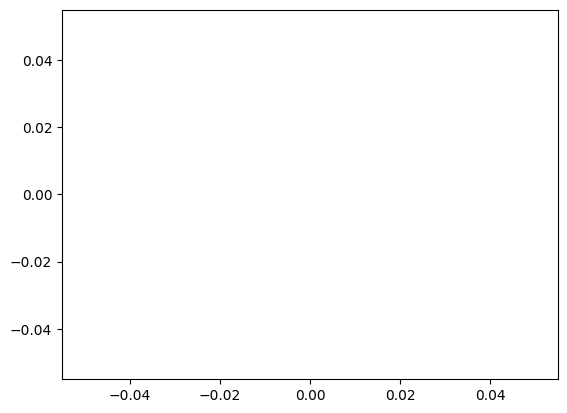

In [69]:
plt.plot(np.arange(0, 4, 0.01), pris)

In [23]:
os.cpu_count()

24

In [26]:
!pip install tqdm-joblib


In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import os
import numpy as np

out_dir = os.path.expanduser('~/Downloads/transmissions/size_10')
os.makedirs(out_dir, exist_ok=True)

ws = np.arange(0, 4, 0.01)
conc_list = np.arange(55, 51, 5)
num_configs = 10000
n_jobs = os.cpu_count()

def save_transmission(conc, config):
    transmission = np.array([device(w, 0.001, 1, 0, size, config, int(conc)) for w in ws])
    fn = os.path.join(out_dir, f'lead_size_{size}_conc_{int(conc)}_config_{config}.csv')
    np.savetxt(fn, np.column_stack((ws, transmission)), delimiter=',', header='w,G', comments='')

for conc in tqdm(conc_list, desc="Concentrations"):
    with tqdm_joblib(tqdm(total=num_configs, desc=f"Configs (conc={int(conc)})")) as progress_bar:
        Parallel(n_jobs=n_jobs, backend="multiprocessing")(
            delayed(save_transmission)(conc, config)
            for config in range(num_configs)
        )


/home/shardul/miniconda3/envs/ml/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Concentrations:   0%|          | 0/10 [00:00<?, ?it/s]



  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  10%|█         | 1/10 [15:56<2:23:25, 956.13s/it]




  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  20%|██        | 2/10 [31:44<2:06:53, 951.74s/it]



  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  30%|███       | 3/10 [47:46<1:51:33, 956.26s/it]




  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  40%|████      | 4/10 [1:03:58<1:36:13, 962.31s/it]



  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  50%|█████     | 5/10 [1:20:23<1:20:53, 970.60s/it]




  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  60%|██████    | 6/10 [1:36:54<1:05:10, 977.52s/it]



  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  70%|███████   | 7/10 [1:53:32<49:13, 984.39s/it]  




  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  80%|████████  | 8/10 [2:10:24<33:06, 993.00s/it]



  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations:  90%|█████████ | 9/10 [2:27:24<16:41, 1001.62s/it]




  0%|          | 0/10000 [00:00<?, ?it/s]

Concentrations: 100%|██████████| 10/10 [2:44:34<00:00, 987.48s/it] 


In [44]:
avgs = {}
cwd = os.path.expanduser('~/Downloads/transmissions/size_10/')
for conc in np.arange(5,51,5):
    
    data = []
    for c in range(10000):
        d1 = np.loadtxt(os.path.join(cwd + f'lead_size_10_conc_{int(conc)}_config_{c}.csv'),delimiter=',',skiprows=1)[:,1]
        data.append(np.clip(d1,0,pris))
    
    avgs[conc] = np.mean(data,axis=0)

    

In [45]:
def misfit(input):
    diff =  [np.sum(np.abs(input - avgs[keys])[:200]) for keys in avgs.keys()]
    return diff, np.min(diff), np.argmin(diff)

In [54]:
input_config = np.loadtxt(os.path.join(cwd + 'lead_size_10_conc_30_config_100.csv'),delimiter=',',skiprows=1)[:,1]
misfit(np.clip(input_config,0,pris))

([np.float64(261.476416294113),
  np.float64(230.42186787552882),
  np.float64(229.39006767029556),
  np.float64(231.54302437832163),
  np.float64(233.89442308183962),
  np.float64(234.93965635874508),
  np.float64(236.1852827843242),
  np.float64(236.99607033331466),
  np.float64(237.7359491960112),
  np.float64(237.51183122518174)],
 np.float64(229.39006767029556),
 np.int64(2))

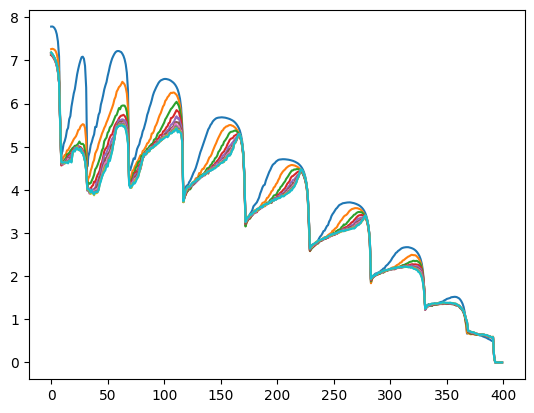

In [57]:
for conc in np.arange(5,51,5):
    plt.plot(avgs[conc])

#plt.plot(np.clip(input_config,0,pris))

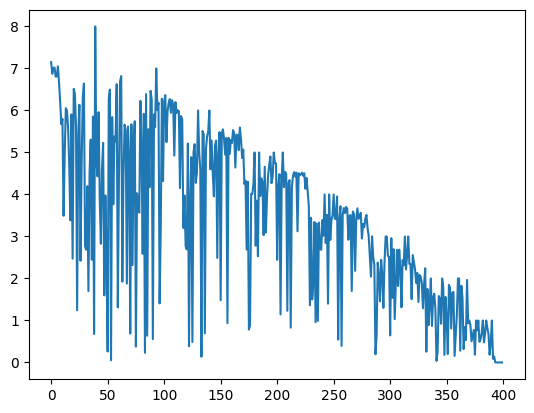

In [56]:
plt.plot(np.clip(input_config,0,pris))